Project Title : Estimating Fire Radiative Power (FRP) in Forest Fires Using Satellite Data

Problem Statement : Forest fires cause severe ecological and economic damage worldwide. Predicting Fire Radiative Power(FRP) is essential to assess fire intensity, spread, and emissions

Description : FRP is a key indicator of fire intensity and emissions, making it vital for monitoring wildfire severity. By using remote sensing data such as brightness, temperature, and location . This project applies Linear Regression to provide quick FRP estimates. The model enables faster decision-making for disaster management, emission assessment, and ecological protection.

In [19]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

In [9]:
from google.colab import files
import pandas as pd

# Upload the file manually
uploaded = files.upload()




In [10]:
# Read CSV into DataFrame
df = pd.read_csv("/content/2000-2021 SINGLE TURKEY FIRE_M-C61_214067 (1).csv")
print(df.head())

   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   36.8527    35.3594       306.0   2.1    1.4  2000-11-01       815   
1   40.5441    35.1786       307.8   1.1    1.0  2000-11-02       857   
2   40.1473    35.0444       305.3   1.1    1.0  2000-11-02       857   
3   40.5421    35.1909       310.0   1.1    1.0  2000-11-02       857   
4   41.2569    31.4172       307.9   1.1    1.0  2000-11-02       857   

  satellite instrument  confidence version  bright_t31   frp daynight  type  
0     Terra      MODIS          60    6.03       294.4  13.2        D   0.0  
1     Terra      MODIS          66    6.03       296.0   5.8        D   0.0  
2     Terra      MODIS          46    6.03       293.5   4.3        D   0.0  
3     Terra      MODIS          69    6.03       296.1   7.3        D   0.0  
4     Terra      MODIS           0    6.03       290.4   8.0        D   2.0  


/tmp/ipython-input-1412662303.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/2000-2021 SINGLE TURKEY FIRE_M-C61_214067 (1).csv")


In [12]:
# Basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211309 entries, 0 to 211308
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    211309 non-null  float64
 1   longitude   211309 non-null  float64
 2   brightness  211309 non-null  float64
 3   scan        211309 non-null  float64
 4   track       211309 non-null  float64
 5   acq_date    211309 non-null  object 
 6   acq_time    211309 non-null  int64  
 7   satellite   211309 non-null  object 
 8   instrument  211309 non-null  object 
 9   confidence  211309 non-null  int64  
 10  version     211309 non-null  object 
 11  bright_t31  211309 non-null  float64
 12  frp         211309 non-null  float64
 13  daynight    211309 non-null  object 
 14  type        205918 non-null  float64
dtypes: float64(8), int64(2), object(5)
memory usage: 24.2+ MB
None


In [11]:
# Statistics of the dataset
df.describe()

,latitude,longitude,brightness,scan,track,acq_time,confidence,bright_t31,frp,type
count,211309.000000,211309.000000,211309.000000,211309.000000,211309.000000,211309.000000,211309.000000,211309.000000,211309.000000,205918.000000
mean,38.096869,35.810523,323.103487,1.519333,1.183241,1127.559252,66.453923,302.475387,30.341675,0.138798
std,1.259144,4.218867,15.710290,0.735847,0.228731,426.703297,19.297827,10.168149,67.171226,0.509481
min,35.822100,25.723600,300.000000,1.000000,1.000000,0.000000,0.000000,265.200000,0.000000,0.000000
25%,37.113200,33.037500,311.300000,1.000000,1.000000,845.000000,55.000000,294.100000,8.900000,0.000000
50%,37.711700,35.817400,322.100000,1.200000,1.100000,1024.000000,68.000000,302.800000,15.300000,0.000000
75%,38.931600,39.755500,331.300000,1.700000,1.300000,1110.000000,79.000000,310.000000,30.700000,0.000000
max,42.033000,44.796700,503.530000,4.820000,2.000000,2359.000000,100.000000,400.100000,4816.680000,3.000000


In [13]:
# Finding the missing value
print(df.isnull().sum())

latitude         0
longitude        0
brightness       0
scan             0
track            0
acq_date         0
acq_time         0
satellite        0
instrument       0
confidence       0
version          0
bright_t31       0
frp              0
daynight         0
type          5391
dtype: int64


In [14]:
# clos
df.columns

Index(['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_t31', 'frp', 'daynight', 'type'],
      dtype='object')

In [15]:
# Convert date
df['acq_date'] = pd.to_datetime(df['acq_date'], errors='coerce')
df['year'] = df['acq_date'].dt.year
df['month'] = df['acq_date'].dt.month

# Encode categorical (Day=1, Night=0)
df['daynight'] = df['daynight'].map({'D':1, 'N':0})

# Drop missing values
df = df.dropna()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 205918 entries, 0 to 205917
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   latitude    205918 non-null  float64       
 1   longitude   205918 non-null  float64       
 2   brightness  205918 non-null  float64       
 3   scan        205918 non-null  float64       
 4   track       205918 non-null  float64       
 5   acq_date    205918 non-null  datetime64[ns]
 6   acq_time    205918 non-null  int64         
 7   satellite   205918 non-null  object        
 8   instrument  205918 non-null  object        
 9   confidence  205918 non-null  int64         
 10  version     205918 non-null  object        
 11  bright_t31  205918 non-null  float64       
 12  frp         205918 non-null  float64       
 13  daynight    205918 non-null  int64         
 14  type        205918 non-null  float64       
 15  year        205918 non-null  int32         
 16  month  

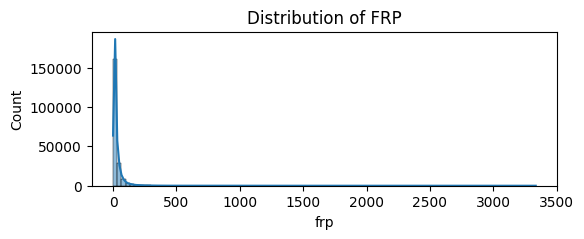

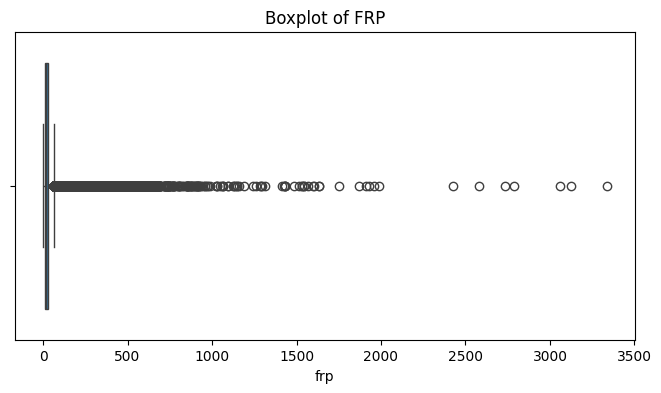

In [25]:
#import matplotlib.pyplot as plt
#import seaborn as sns

plt.figure(figsize=(6,2))
sns.histplot(df['frp'], bins=100, kde=True)
plt.title("Distribution of FRP")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df['frp'])
plt.title("Boxplot of FRP")
plt.show()

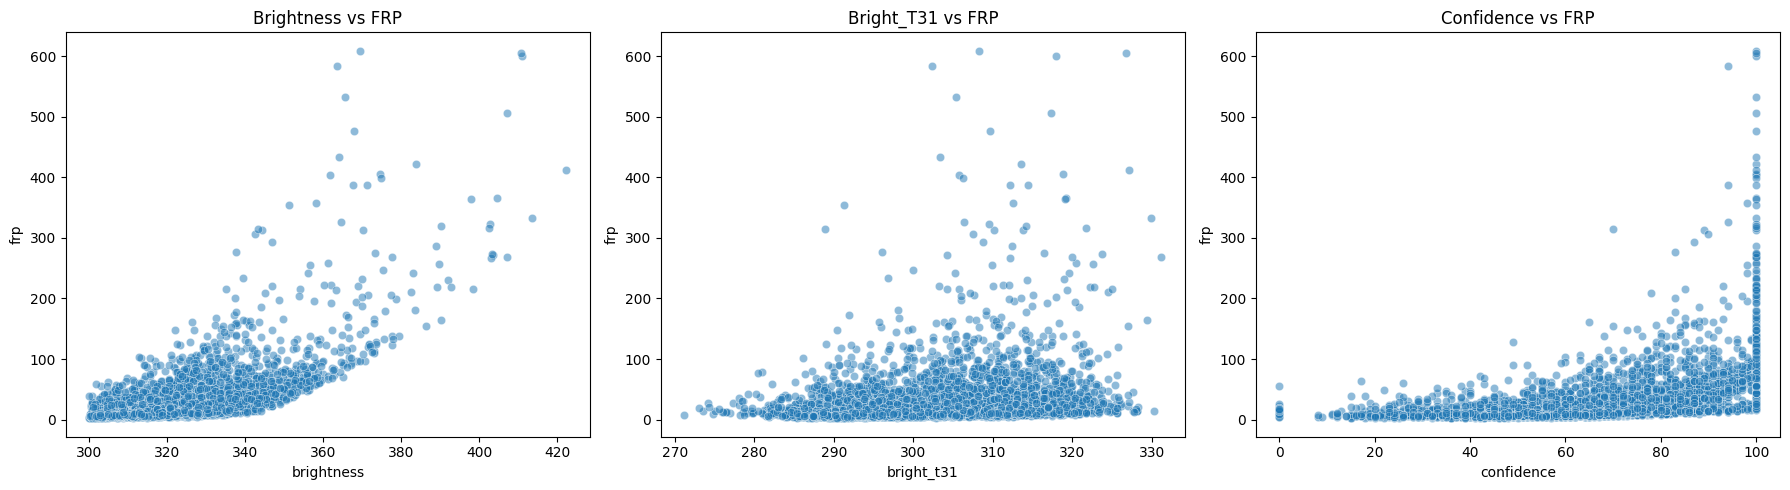

In [27]:
sample_df = df.sample(5000, random_state=42)

fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.scatterplot(x='brightness', y='frp', data=sample_df, alpha=0.5, ax=axes[0])
axes[0].set_title("Brightness vs FRP")

sns.scatterplot(x='bright_t31', y='frp', data=sample_df, alpha=0.5, ax=axes[1])
axes[1].set_title("Bright_T31 vs FRP")

sns.scatterplot(x='confidence', y='frp', data=sample_df, alpha=0.5, ax=axes[2])
axes[2].set_title("Confidence vs FRP")

plt.tight_layout()
plt.show()

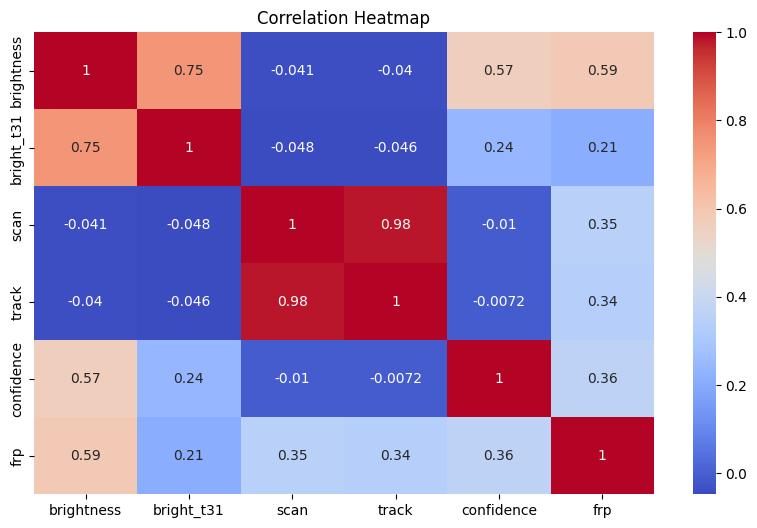

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['brightness','bright_t31','scan','track','confidence','frp']].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

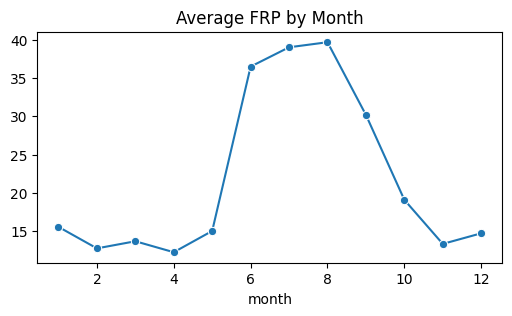

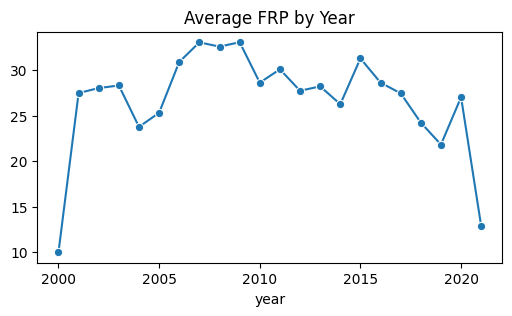

In [28]:
# Monthly FRP
plt.figure(figsize=(6,3))
monthly_frp = df.groupby('month')['frp'].mean()
sns.lineplot(x=monthly_frp.index, y=monthly_frp.values, marker="o")
plt.title("Average FRP by Month")
plt.show()

# Yearly FRP
plt.figure(figsize=(6,3))
yearly_frp = df.groupby('year')['frp'].mean()
sns.lineplot(x=yearly_frp.index, y=yearly_frp.values, marker="o")
plt.title("Average FRP by Year")
plt.show()

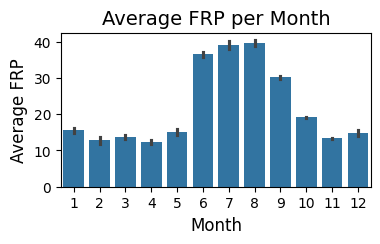

In [29]:
plt.figure(figsize=(4,2))
sns.barplot(x='month', y='frp', data=df)

plt.xlabel("Month", fontsize=12)
plt.ylabel("Average FRP", fontsize=12)
plt.title("Average FRP per Month", fontsize=14)

plt.show()

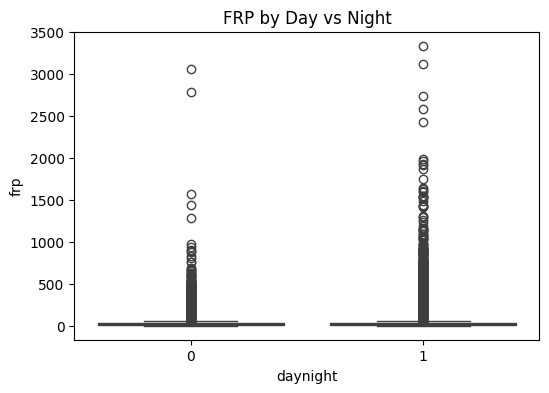

In [32]:
plt.figure(figsize=(6,4))
sns.boxplot(x='daynight', y='frp', data=df)
plt.title("FRP by Day vs Night")
plt.show()

In [38]:
# Define features & target
features = ['brightness','bright_t31','confidence','scan','track','month','year','daynight']
X = df[features]
y = df['frp']

In [40]:
# split data into training and tests sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
.shapeX_train

(164734, 8)

In [43]:
X_test.shape

(41184, 8)

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Before Scaling:\n", X.head())
print("\nAfter Scaling (first 5 rows):\n", X_scaled[:5])

Before Scaling:
    brightness  bright_t31  confidence  scan  track  month  year  daynight
0       306.0       294.4          60   2.1    1.4     11  2000         1
1       307.8       296.0          66   1.1    1.0     11  2000         1
2       305.3       293.5          46   1.1    1.0     11  2000         1
3       310.0       296.1          69   1.1    1.0     11  2000         1
4       307.9       290.4           0   1.1    1.0     11  2000         1

After Scaling (first 5 rows):
 [[-1.10086837 -0.78634486 -0.32577351  0.80146685  0.95937367  1.33226007
  -2.11543941  0.4566133 ]
 [-0.98305594 -0.62868875 -0.01174468 -0.56762125 -0.79933963  1.33226007
  -2.11543941  0.4566133 ]
 [-1.14668431 -0.87502642 -1.05850745 -0.56762125 -0.79933963  1.33226007
  -2.11543941  0.4566133 ]
 [-0.83906297 -0.61883524  0.14526974 -0.56762125 -0.79933963  1.33226007
  -2.11543941  0.4566133 ]
 [-0.9765108  -1.18048513 -3.46606184 -0.56762125 -0.79933963  1.33226007
  -2.11543941  0.4566133 ]]


In [46]:
X_train

,brightness,bright_t31,confidence,scan,track,month,year,daynight
50252,335.7,309.0,78,2.7,1.6,8,2007,1
149535,338.0,304.6,85,1.4,1.2,9,2015,1
97097,331.9,316.9,55,1.3,1.1,7,2011,1
115564,339.9,312.0,83,1.2,1.1,6,2012,1
17105,332.7,314.1,67,1.6,1.3,8,2003,1
...,...,...,...,...,...,...,...,...
119879,308.2,296.4,62,1.0,1.0,11,2012,1
103694,325.4,311.2,34,1.1,1.1,9,2011,1
131932,303.8,292.1,57,1.5,1.2,1,2014,1
146867,337.2,317.9,74,1.2,1.1,8,2015,1
